# Show point clouds

# table of content
1) [Showing las pointcloud](#showing-las-pointclouds)
2) [Different file format generation](#different-file-format-generation)
3) [Semantic splitting](#semantic-splitting)
4) [Instance splitting](#instances-splitting)

### Dependencies and general utils

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import open3d as o3d
import laspy
import pdal
import json
from tqdm import tqdm

In [2]:
def load_laz(file_path):
    las = laspy.read(file_path)
    points = np.vstack((las.x, las.y, las.z)).transpose()  # Extract XYZ coordinates
    return points

### Showing las pointclouds

#### Utils

In [3]:
def print_camera_info(vis):
    ctr = vis.get_view_control()

    saved_cam_params = ctr.convert_to_pinhole_camera_parameters()

    # Extract parameters
    intrinsic = saved_cam_params.intrinsic.intrinsic_matrix
    extrinsic = saved_cam_params.extrinsic
    fov = ctr.get_field_of_view()

    print("\nCamera Parameters:")
    print(f"Intrinsic Matrix:\n{intrinsic}")
    print(f"Extrinsic Matrix:\n{extrinsic}")
    print(f"Field of View: {fov} degrees\n")
    return False  # Do not block the visualization loop


def apply_camera_params(vis, intrinsic, extrinsic, fov):
    ctr = vis.get_view_control()

    # Convert to Open3D format
    cam_params = ctr.convert_to_pinhole_camera_parameters()
    # cam_params.intrinsic.set_intrinsics(1280, 720, intrinsic[0][0], intrinsic[1][1], intrinsic[0][2], intrinsic[1][2])
    cam_params.extrinsic = np.array(extrinsic)

    # Apply settings
    ctr.convert_from_pinhole_camera_parameters(cam_params)
    # ctr.set_field_of_view(fov)

    return False


def visualize_laz(file_path, mode='normal', display_mode='3d', image_dest_src=None):
    # Load point cloud
    # pcd = o3d.io.read_point_cloud(file_path)  # Replace with your file

    # assert not semantic == instance == True
    assert mode in ['normal', 'instance', 'semantic']
    assert display_mode in ['3d', 'image']

    laz = laspy.read(file_path)
    points = load_laz(file_path)
 
    if mode == 'semantic':
        cat = getattr(laz, 'PredSemantic')
        colors = np.zeros((cat.size, 3))
        colors[np.arange(cat.size), cat] = 1

    if mode == 'instance':
        # list of colors
        list_colors = [
            (1.00, 0.00, 0.00), (0.00, 1.00, 0.00), (0.00, 0.00, 1.00), (1.00, 1.00, 0.00), (1.00, 0.00, 1.00),
            (0.00, 1.00, 1.00), (0.50, 0.00, 0.00), (0.50, 0.50, 0.00), (0.00, 0.50, 0.00), (0.50, 0.00, 0.50),
            (0.00, 0.50, 0.50), (0.00, 0.00, 0.50), (1.00, 0.65, 0.00), (0.65, 0.16, 0.16), (0.54, 0.17, 0.89),
            (0.37, 0.62, 0.63), (0.50, 1.00, 0.00), (0.86, 0.08, 0.24), (1.00, 0.84, 0.00), (0.29, 0.00, 0.51)
        ]

        cat = getattr(laz, 'PredInstance')
        colors = np.zeros((cat.size, 3))
        for i in range(cat.size):
            colors[i, :] = list_colors[cat[i] % len(list_colors)]
        

    # Convert numpy array to Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    if mode in ['semantic', 'instance']:
        pcd.colors = o3d.utility.Vector3dVector(colors)
        
    # Create visualizer
    vis = o3d.visualization.VisualizerWithKeyCallback()
    vis.create_window()
    vis.add_geometry(pcd)


    # declare camera state matrices and apply them
    intrinsic = [[872.08758161, 0., 959.5],
                 [0., 872.08758161, 503.],
                 [0., 0., 1.]]
    # extrinsic = [[ 8.84060103e-01, -4.64626502e-01, 5.05959387e-02, -1.76422251e+06],
    # [-1.83497140e-01, -4.44617652e-01, -8.76723413e-01, 9.61322005e+05],
    # [4.29844780e-01, 7.65791981e-01, -4.78326361e-01, -1.94482077e+06],
    # [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]
    extrinsic = [
    [-0.758331017,  0.650583929,  0.0409221173,  1236660.87],
    [ 0.298649636,  0.402539622, -0.865315115, -1208259.24],
    [-0.579432881, -0.643973916, -0.499554934,  2197873.97],
    [ 0.0,          0.0,          0.0,          1.0]
]

    fov = 60.0
    apply_camera_params(vis, intrinsic, extrinsic, fov)

    if display_mode == '3d':
        # Assign 'C' key (67 in ASCII) to print camera vectors
        vis.register_key_callback(67, print_camera_info)  # Press 'C' to print vectors

        # Run visualization
        vis.run()
        vis.destroy_window()
    else:
        # 🔹 Step 3: Capture rendered image
        image = vis.capture_screen_float_buffer(do_render=True)  # Get image as a NumPy array
        vis.destroy_window()  # Close the visualizer

        # 🔹 Step 4: Convert and show image with Matplotlib
        fig = plt.figure(figsize=(10,10))
        image_np = np.asarray(image)  # Convert to NumPy array
        plt.imshow(image_np)
        plt.axis("off")  # Hide axes
        plt.show()
        if image_dest_src:
            plt.imsave(image_dest_src, image_np)

# Convert to Open3D PointCloud and visualize
def visualize_laz_base(file_path, segmented = False):
    laz = laspy.read(file_path)
    points = load_laz(file_path)

    if segmented:
        cat = getattr(laz, 'PredSemantic')
        colors = np.zeros((cat.size, 3))
        colors[np.arange(cat.size), cat] = 1
    
    # Convert numpy array to Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    if segmented:
        pcd.colors = o3d.utility.Vector3dVector(colors)

    o3d.visualization.draw_geometries([pcd],
                                  up=[-0.01603346, -0.87699978, -0.48022319],
                                  front=[-0.15798422, -0.47202973,  0.86731132],
                                  )

#### Declare sample paths

In [4]:
src_test_file = "../data/testing_samples/split_0332.laz"
src_test_file_segmented = "../data/testing_samples/split_0332_out.laz"

#### Show different versions

[Open3D WARNING] [ViewControl] ConvertFromPinholeCameraParameters() failed because window height and width do not match.


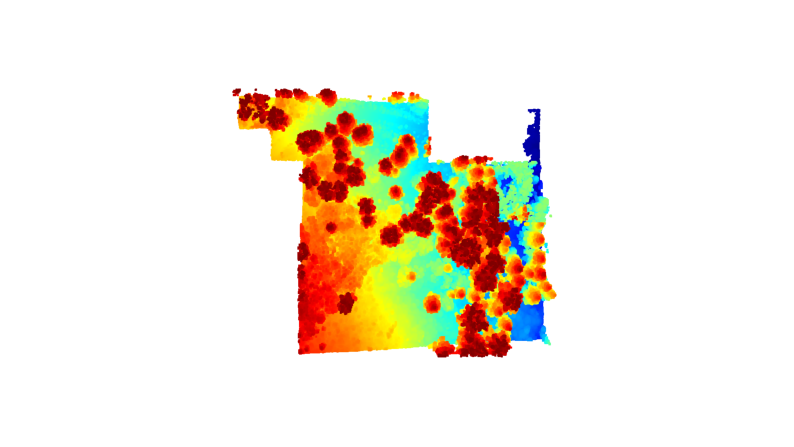

In [5]:
# Visualize original file
src_out_image = src_test_file.split('.laz')[0] + '_original.png'
visualize_laz(src_test_file, display_mode='image', image_dest_src=None)

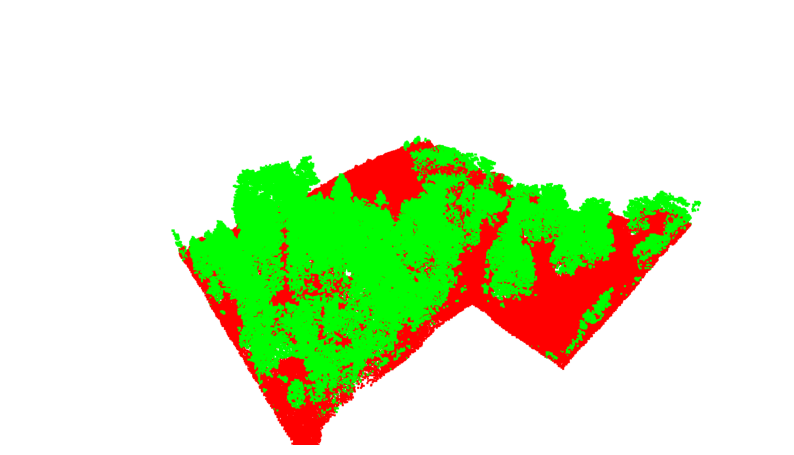

In [ ]:
# Visualize semantic segmentation
src_out_image = src_test_file_segmented.split('_out.laz')[0] + '_semantic.png'
visualize_laz(src_test_file_segmented, mode='semantic', display_mode='image', image_dest_src=None)

In [18]:
# Visualize instance segmentation
src_out_image = src_test_file_segmented.split('_out.laz')[0] + '_instance.png'
visualize_laz(src_test_file_segmented, mode='instance', display_mode='3d', image_dest_src=None)

### Different file format generation

#### Utils

In [5]:
def convert_laz_to_las(in_laz, out_las, verbose=True):
    las = laspy.read(in_laz)
    las = laspy.convert(las)
    las.write(out_las)
    if verbose:
        print(f"LAS file saved in {out_las}")

def convert_pcd_to_laz(in_pcd, out_laz, verbose=True):
    # pcd = laspy.read('../data/testing_samples/split_0332.pcd')
    pipeline_json = {
        "pipeline": [
            in_pcd,  # Read the PCD file
            {
                "type": "writers.las",
                "filename": out_laz,
                "compression": "laszip"  # Ensures .laz compression
                ""
            },
            {
                "type": "filters.reprojection",
                "in_srs": "EPSG:4326",
                "out_srs": "EPSG:2056"
            }
        ]
    }

    # Run the PDAL pipeline
    pipeline = pdal.Pipeline(json.dumps(pipeline_json))
    pipeline.execute()
    
    if verbose:
        print(f"LAZ file saved in {out_laz}")

def convert_laz_to_pcd(in_laz, out_pcd, verbose=True):
    laz = laspy.read(in_laz)

    # Gathering all attributes from laz file
    points = np.vstack((laz.x, laz.y, laz.z)).T

    attributes = {}
    for attribute in laz.point_format.dimensions:
        if attribute.name in ['X', 'Y', 'Z']:
            continue
        attributes[attribute.name] = getattr(laz, attribute.name)
    
    # Preparing data for pcd
    num_points = points.shape[0]
    fields = ["x", "y", "z"] + list(attributes.keys())  # All field names
    types = ["F", "F", "F"] + ["F" for _ in attributes]  # Float32 fields
    sizes = [4] * len(fields)  # 4-byte float per field

    # Stack all data into a single NumPy array
    data = np.column_stack([points] + [attributes[key] for key in attributes])

    # Write to a PCD file
    with open(out_pcd, "w") as f:
        # f.write(f"# .PCD v0.7 - Point Cloud Data file format\n")
        f.write(f"VERSION 0.7\n")
        f.write(f"FIELDS {' '.join(fields)}\n")
        f.write(f"SIZE {' '.join(map(str, sizes))}\n")
        f.write(f"TYPE {' '.join(types)}\n")
        f.write(f"COUNT {' '.join(['1'] * len(fields))}\n")
        f.write(f"WIDTH {num_points}\n")
        f.write(f"HEIGHT 1\n")
        f.write(f"VIEWPOINT 0 0 0 1 0 0 0\n")
        f.write(f"POINTS {num_points}\n")
        f.write(f"DATA ascii\n")
    
        # Write data
        np.savetxt(f, data, fmt=" ".join(["%.6f"] * len(fields)))

    if verbose:
        print(f"PCD file saved in {out_pcd}")


# convert_pcd_to_laz(r"C:\temp_stockage_pdm\PDM_repos\Data_samples_cat\Single\color_grp_000020.pcd",r"C:\temp_stockage_pdm\PDM_repos\Data_samples_cat\Single\color_grp_000020.laz")

#### Transform laz to las and pcd

In [6]:
# From laz to las
for file_in in [src_test_file, src_test_file_segmented]:
    file_out = file_in.split('.laz')[0] + '.las'
    convert_laz_to_las(file_in, file_out)

LAS file saved in ../data/testing_samples/split_0332.las
LAS file saved in ../data/testing_samples/split_0332_out.las


In [ ]:
# From laz to pcd
for file_in in [src_test_file, src_test_file_segmented]:
    file_out = file_in.split('.laz')[0] + '.pcd'
    convert_laz_to_pcd(file_in, file_out)

PCD file saved in ../data/testing_samples/split_0332.pcd
PCD file saved in ../data/testing_samples/split_0332_out.pcd


### Semantic splitting

#### Utils

In [ ]:
def split_semantic(src, show_images=False, verbose=True):
    # Define target folder:
    dir_target = os.path.dirname(src) + '/' + src.split('/')[-1].split('.')[0] + "_split_semantic"

    if not os.path.exists(dir_target):
        os.makedirs(dir_target)

    points_segmented = laspy.read(src_test_file_segmented)
    val_to_name = ['ground', 'tree']

    for val, name in enumerate(val_to_name):
        file_name = src_test_file_segmented.split('\\')[-1].split('/')[-1].split('.laz')[0] + f'_{name}.laz'
        file_src = os.path.join(dir_target, file_name)

        # create new file
        # new_file = laspy.create(point_format=points_segmented.header.point_format, file_version=points_segmented.header.version)
        # new_file.points = points_segmented.points[points_segmented.PredSemantic == val]
        # new_file.write(file_src, do_compress=True)

        # Define the PDAL pipeline for filtering
        pipeline_json = {
            "pipeline": [
                src,
                {
                    "type": "filters.expression",
                    "expression": f"PredSemantic == {val}"
                },
                file_src
            ]
        }

        # Run PDAL pipeline
        pipeline = pdal.Pipeline(json.dumps(pipeline_json))
        pipeline.execute()
        
        # convert new file
        convert_laz_to_las(file_src, file_src.split('.laz')[0] + '.las', verbose=verbose)
        convert_laz_to_pcd(file_src, file_src.split('.laz')[0] + '.pcd', verbose=verbose)
        if show_images:
            visualize_laz(file_src, mode='normal', display_mode='image')
    if verbose:
        print("SEMANTIC SPLITTING DONE")


#### Splitting

[Open3D WARNING] [ViewControl] ConvertFromPinholeCameraParameters() failed because window height and width do not match.


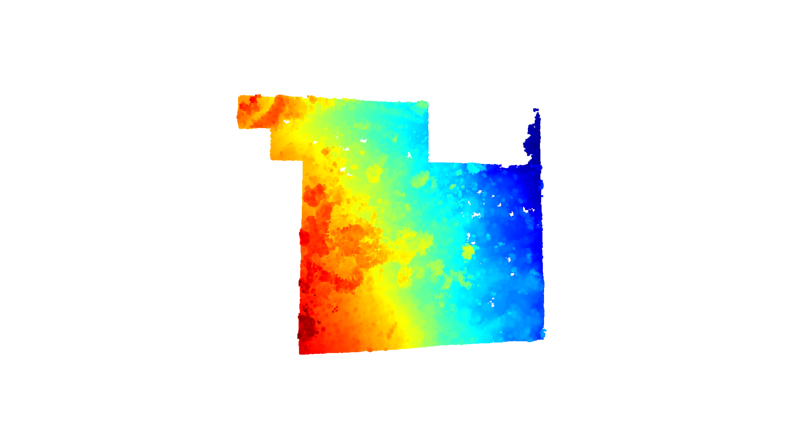

[Open3D WARNING] [ViewControl] ConvertFromPinholeCameraParameters() failed because window height and width do not match.


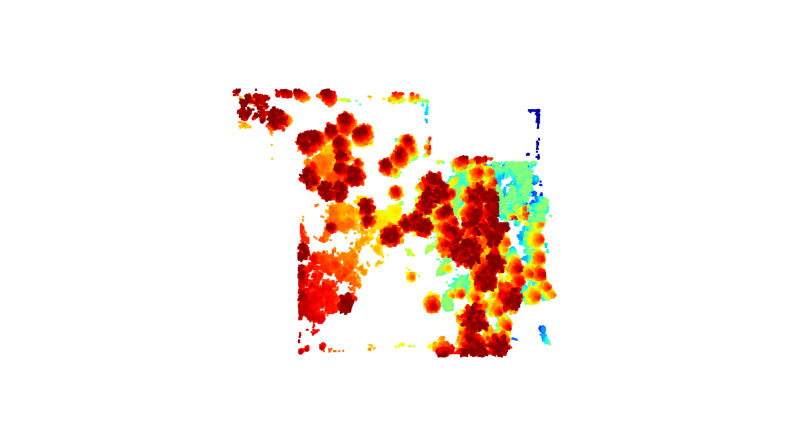

In [14]:
split_semantic(src_test_file_segmented, show_images=True, verbose=False)

### Instances splitting

#### Utils

In [6]:
def split_instance(src, show_images=False, verbose=True):
    # Define target folder:
    dir_target = os.path.dirname(src) + '/' + src.split('/')[-1].split('.')[0] + "_split_instance"

    if not os.path.exists(dir_target):
        os.makedirs(dir_target)

    points_segmented = laspy.read(src_test_file_segmented)

    for idx, instance in tqdm(enumerate(set(points_segmented.PredInstance)), total=len(set(points_segmented.PredInstance))):
        file_name = src_test_file_segmented.split('\\')[-1].split('/')[-1].split('.laz')[0] + f'_{instance}.laz'
        file_src = os.path.join(dir_target, file_name)

        # create new file
        # new_file = laspy.create(point_format=points_segmented.header.point_format, file_version=points_segmented.header.version)
        # new_file.points = points_segmented.points[points_segmented.PredInstance == instance]
        # # print(list(new_file.point_format.dimension_names))
        # # print(new_file.PredInstance)
        # # continue
        # new_file.write(file_src)

        # Define the PDAL pipeline for filtering
        pipeline_json = {
            "pipeline": [
                src,
                {
                    "type": "filters.expression",
                    "expression": f"PredInstance == {instance}"
                },
                file_src
            ]
        }

        # Run PDAL pipeline
        pipeline = pdal.Pipeline(json.dumps(pipeline_json))
        pipeline.execute()

        # convert new file
        convert_laz_to_las(file_src, file_src.split('.laz')[0] + '.las', verbose=False)
        convert_laz_to_pcd(file_src, file_src.split('.laz')[0] + '.pcd', verbose=False)
        if show_images:
            visualize_laz(file_src, mode='normal', display_mode='image')

    if verbose:
        print("INSTANCE SPLITTING DONE")


#### Splitting

In [7]:
split_instance(src_test_file_segmented, show_images=False, verbose=False)

100%|██████████| 284/284 [01:10<00:00,  4.02it/s]


### Transform all pcd files of a folder into laz files

In [7]:
src_folder = r"C:\temp_stockage_pdm\PDM_repos\Data_samples_cat\Single"
list_files = os.listdir(src_folder)
for _, file in tqdm(enumerate(list_files), total=len(list_files)):
    if file.endswith('.pcd'):
        src_in = os.path.join(src_folder, file)
        src_out = os.path.join(src_folder, file.split('.pcd')[0] + '.laz')
        convert_pcd_to_laz(src_in, src_out,verbose=False)

100%|██████████| 3806/3806 [09:00<00:00,  7.04it/s]


### RANDOM STUFF

In [23]:
points = laspy.read(src_test_file)
points_segmented = laspy.read(src_test_file_segmented)

# List available attributes
print("Available point attributes in original file:")
print(list(points.point_format.dimension_names))

print("Available point attributes in segmented file:")
print(list(points_segmented.point_format.dimension_names))



Available point attributes in original file:
['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'synthetic', 'key_point', 'withheld', 'scan_angle_rank', 'user_data', 'point_source_id', 'red', 'green', 'blue', 'Distance', 'Group', 'Normal']
Available point attributes in segmented file:
['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'synthetic', 'key_point', 'withheld', 'overlap', 'scanner_channel', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'user_data', 'scan_angle', 'point_source_id', 'gps_time', 'red', 'green', 'blue', 'Distance', 'Normal', 'Group', 'PredSemantic', 'gt_semantic_segmentation', 'PredInstance']


In [25]:
print(set(points_segmented.PredSemantic))
for val in set(points_segmented.PredSemantic):
    print(f"Number of point of class {val}: {len([x for x in points_segmented.PredSemantic if x == val])}")

{0, 1}
Number of point of class 0: 305864
Number of point of class 1: 200852


In [33]:
visualize_laz(src_test_file_segmented, True)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
